# Job postings descriptions

This notebook contains some analysis of job postings descriptions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [2]:
def get_interest(x):
    if x in ['Business Analysis', 'Big Data', 'Business Intelligence', 'AI']:
        return 1
    return 0

In [3]:
# there were some postings with none descriptions, they were deleted previously
df = pd.read_csv('job_postings.csv')
df['interest'] = df.apply(lambda x: get_interest(x['main_category']), axis=1)

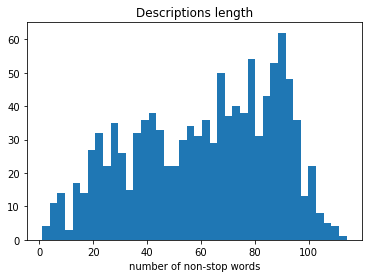

In [4]:
descrs_length = df['description_preprocessed'].to_list()
descrs_length = [len(d.split(' ')) for d in descrs_length]
plt.hist(descrs_length, bins=40)
plt.title('Descriptions length')
plt.xlabel('number of non-stop words')
plt.show()

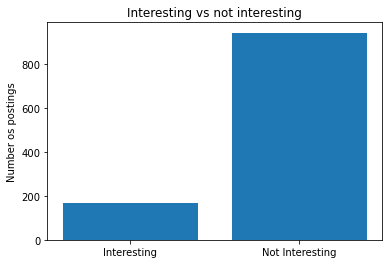

In [5]:
interesting = sum(df['interest'])
plt.bar(['Interesting', 'Not Interesting'], [interesting, df.shape[0] - interesting])
plt.title('Interesting vs not interesting')
plt.ylabel('Number os postings')
plt.show()

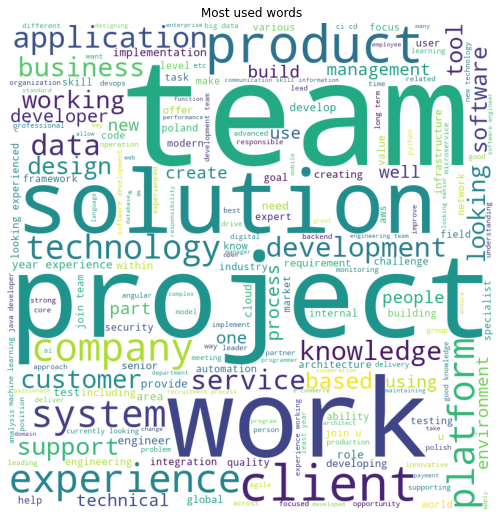

In [6]:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(' '.join(df['description_preprocessed'].to_list()))

plt.figure(figsize=(7, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most used words')
plt.tight_layout(pad=0)
plt.show()

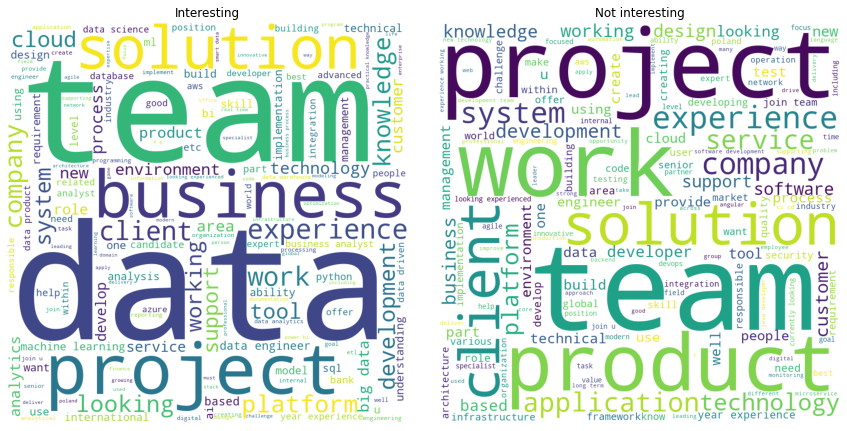

In [7]:
wordcloud_interesting = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(' '.join(df[df.interest==1]['description_preprocessed'].to_list()))

wordcloud_not_interesting = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(' '.join(df[df.interest==0]['description_preprocessed'].to_list()))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
f.tight_layout(pad=0)

ax1.imshow(wordcloud_interesting)
ax1.set_title('Interesting')
ax1.axis("off")

ax2.imshow(wordcloud_not_interesting)
ax2.set_title('Not interesting')
ax2.axis("off")

plt.show()

In [8]:
# load pretrained model
model = joblib.load('kneighbors.pkl')
# prepare data for visualization
pipeline = Pipeline([('vectorize', TfidfVectorizer()),
                     ('svd', TruncatedSVD(n_components=20, random_state=123))])
X = pipeline.fit_transform(df['description_preprocessed'])
X = TSNE(n_components=2, perplexity=20, random_state=123).fit_transform(X)

In [9]:
# not great not bad
scores = cross_validate(model, df['description_preprocessed'], df['interest'], 
                        scoring=['f1', 'accuracy'], cv=5, return_train_score=True)
print(f'f1 score \n train: {np.mean(scores["train_f1"])}, test: {np.mean(scores["test_f1"])}')
print(f'accuracy \n train: {np.mean(scores["train_accuracy"])}, test: {np.mean(scores["test_accuracy"])}')

f1 score 
 train: 0.5906682202563782, test: 0.5510073120157155
accuracy 
 train: 0.9038802262935148, test: 0.8962251844604786


In [10]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(df['description_preprocessed'], df['interest'])
print(f'dummy f1 score: {f1_score(dummy.predict(df["description_preprocessed"]), df["interest"])}')

dummy f1 score: 0.260596546310832


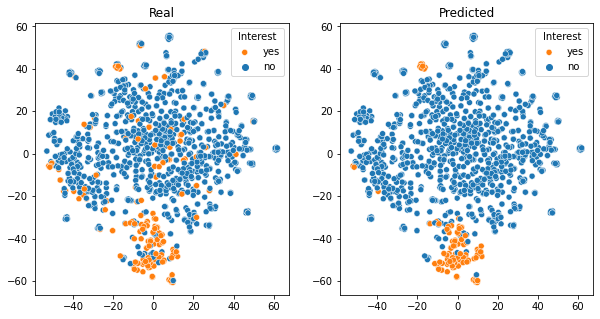

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=X[:, 0], y=X[:, 1], 
                hue=df['interest'], 
                ax=ax1)
ax1.set_title('Real')
ax1.legend(title='Interest', labels=['yes', 'no'])

sns.scatterplot(x=X[:, 0], y=X[:, 1], 
                hue=model.predict(df['description_preprocessed']), 
                ax=ax2)
ax2.set_title('Predicted')
ax2.legend(title='Interest', labels=['yes', 'no'])

plt.show()